In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./svm_utils.py')
from svm_utils import *
from sklearn import datasets

from dataclasses import dataclass

from scipy import optimize
from scipy.optimize import Bounds

In [33]:
@dataclass
class HardMarginSVM:
    learning_rate: float
    lamda: float
    n_iter: int =100000

    def fit(self, X,y):
        n_samples = X.shape[0]
        y = np.where(y<=0, -1, 1)

        self.w = np.zeros(X.shape[1])
        self.b = 0

        for _ in range(self.n_iter):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w + self.b)) >=1
                              
                if condition:
                    self.w = self.w - self.learning_rate * (2 * self.lamda * self.w)

                else:
                    self.w = self.w - self.learning_rate * (2 * self.lamda * self.w - np.dot(x_i, y[idx]))
                    self.b = self.b - self.learning_rate * (-y[idx])
    
    def predict(self, X):
        pred = np.dot(X, self.w) + self.b
        return np.sign(pred)

In [34]:
X,y = datasets.make_blobs(n_samples = 1000, n_features = 2, centers = 2, cluster_std = 1.005,
                            random_state = 40)

In [35]:
clf = HardMarginSVM(learning_rate = 0.00001, lamda = 0.001)
clf.fit(X,y)


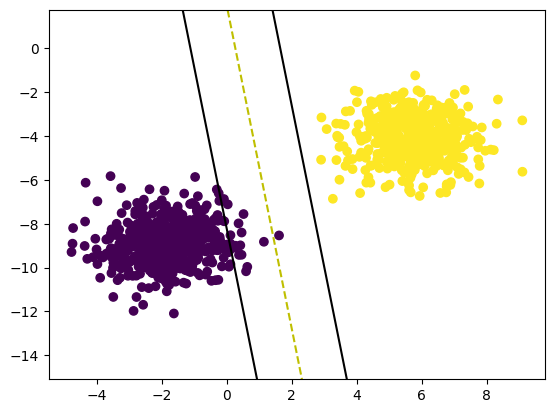

In [36]:
visualize_svm(X,y,clf)

In [38]:
N = 1000
nFeatures = 2
X,y = generateBatchBipolar(N, sigma = 0.4)

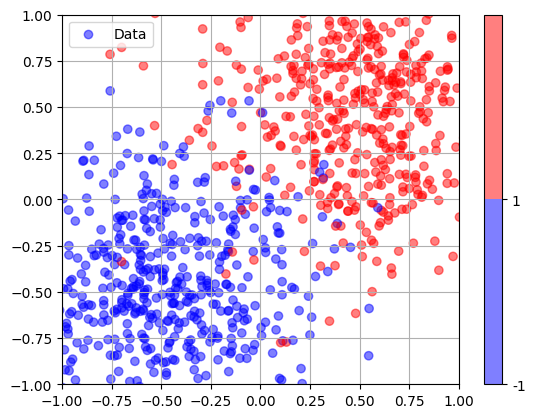

In [39]:
plotSvm(X,y)

In [52]:
class SoftMarginSVM:
    def __init__(self,C):
        self.C = C
    def fit(self, X, y):
        Xy = X*y[:,np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        def ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        def derivative(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        alpha = np.ones(X.shape[0])
        bounds_alpha = Bounds(np.zeros(X.shape[0]), np.full(X.shape[0], self.C))

        constraints = ({'type': 'eq', 'fun': lambda a: np.dot(a, y),
                        'jac': lambda a: y})
        
        optimizer = optimize.minimize(fun = lambda a: ld0(GramXy, a),
                                        x0 = alpha,
                                        jac = lambda a: -derivative(GramXy, a),
                                        constraints = constraints,
                                        bounds = bounds_alpha)

        self.alpha = optimizer.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis = 0)

        epsilon = 1e-4
        self.support_vectors = X[self.alpha > epsilon]
        self.support_labels = y[self.alpha > epsilon]

        b = []
        for i in range (len(self.support_vectors)):
            b_i = self.support_labels[i] - np.matmul(self.support_vectors[i].T, self.w)
            b.append(b_i)

        self.intercept = sum(b)/ len(b)


In [53]:
model = SoftMarginSVM(C = 5)
model.fit(X, y)

AttributeError: 'SoftMarginSVM' object has no attribute 'intercept'

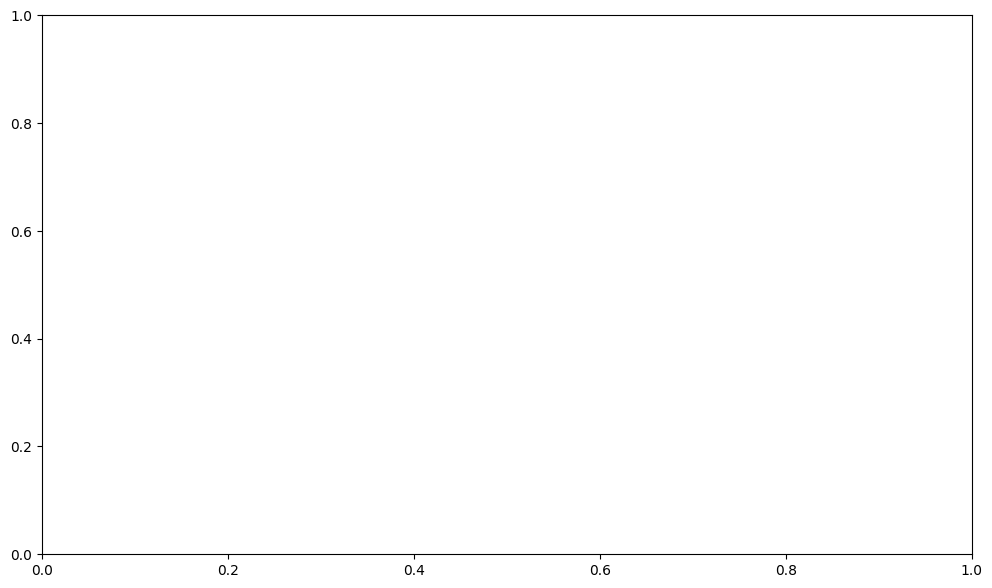

In [51]:
fig, ax = plt.subplots(1,figsize = (12,7))
plotSvm(X, y, model.support_vectors, model.w, model.intercept,
        label = 'training', ax = ax)

In [ ]:
#Soft Margin SVM
class SoftMarginSVM:
    def __init__(self,C, max_iter = 2):
        self.C = C
        self.max_iter = max_iter
    def fit(self, X, y):
        #print("Started new iteration")
        Xy = X*y[:,np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)
        #print("calculated gram matrix")

        def ld0(G, alpha):
            #print("Calculated objective function")
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        def derivative(G, alpha):
            print("calculated derivative)")
            return np.ones_like(alpha) - alpha.dot(G)

        alpha = np.ones(X.shape[0])
        bounds_alpha = Bounds(np.zeros(X.shape[0]), np.full(X.shape[0], self.C))

        constraints = ({'type': 'eq', 'fun': lambda a: np.dot(a, y),
                        'jac': lambda a: y})

        self.iteration_count = 0

        def callback(xk):
            self.iteration_count += 1
            # Print progress every 10 iterations (or any number you choose)
            if self.iteration_count % 1 == 0:
                print(f'Iteration {self.iteration_count} complete')
               
        
        optimizer = optimize.minimize(fun = lambda a: ld0(GramXy, a),
                                        x0 = alpha,
                                        jac = lambda a: -derivative(GramXy, a),
                                        constraints = constraints,
                                        bounds = bounds_alpha,
                                        method='SLSQP', 
                                        options={'maxiter': self.max_iter, 'disp': True},
                                        callback = callback
                                        )


        self.alpha = optimizer.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis = 0)

        epsilon = 1e-4
        self.support_vectors = X[self.alpha > epsilon]
        self.support_labels = y[self.alpha > epsilon]

        b = []
        for i in range (len(self.support_vectors)):
            b_i = self.support_labels[i] - np.matmul(self.support_vectors[i].T, self.w)
            b.append(b_i)

        intercept = sum(b)/ len(b)